In [1]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc

import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [3]:
### START WITH A SINGLE DAY
time = dt.datetime(2019,9,1)

# tw = relativedelta(days=1)
tw = relativedelta(days=1)


In [4]:
#$### map projection
m = ccrs.SouthPolarStereo()
proj_cart = ccrs.PlateCarree() 

In [5]:
#### here is some code for track to track comparisons for Ant+
#### we start with the merged product

root = 'Example_Merge/'
mode = 'SAR-A'
files = glob.glob(root+mode+time.strftime('/%Y/%m/')+'*.nc')
fig_dir= root+mode+time.strftime('/%Y/%m/')
files.sort()
Lmax = len(files)
print(len(files))

39


In [8]:
track=ant_plus.CS2_track(files[0],add_attr=True)
track.print_time()

2019-09-01T00:03:28.418137--2019-09-01T00:06:11.880199


In [39]:
# track.list_vars(['ANOM','flag',])
load_list = track.list_vars()
load_list.sort()
load_list

['NSIDC_nasa',
 'alt_20_ku',
 'atm_corrections_sum_L2',
 'atm_geo_corrections_sum_ANOM_ISat',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD',
 'atm_geo_corrections_sum_ISat',
 'atm_geo_corrections_sum_ISat_Ice',
 'atm_geo_corrections_sum_LEGOS_GPOD',
 'flag_freeboard_20_ku',
 'flag_height_20_ku',
 'flag_surf_type_20_ku_CLS',
 'flag_surf_type_20_ku_LEGOS_GPOD',
 'flag_surf_type_class_20_ku',
 'freeboard_20_ku',
 'geo_corrections_sum_L2',
 'geoid_20_ku',
 'height_1_20_ku',
 'height_1_20_ku_CLS',
 'hf_fluct_total_cor_to_20_ku',
 'inv_bar_cor_to_20_ku',
 'iono_cor_gim_to_20_ku',
 'lat_20_ku',
 'load_tide_to_20_ku',
 'lon_20_ku',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU21',
 'mean_sea_surf_20_ku_DTU15',
 'mean_sea_surf_20_ku_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_LEGOS_GPOD_DTU21',
 'mean_sea_surf_sea_ice_20_ku',
 'mod_dry_tropo_cor_to_20_ku',
 'mod_wet_tropo_cor_to_20_ku',
 'ocean_tide_20_ku_ANOM_DTU_fes',
 'oc

In [40]:
load_list = track.list_vars(['ANOM'])
track.add_vars(load_list)
load_list = track.list_vars(['surf'])
track.add_vars(load_list)
load_list = track.list_vars(['interp','free'])
track.add_vars(load_list)
load_list = track.list_vars(['range','alt','NSIDC','ssha'])
track.add_vars(load_list)

In [21]:
track.vars = [p for p in track.vars if 'SWH_MSSfixed' not in p]

In [22]:
track.mean_sea_surf_20_ku_ANOM_DTU15_attr


{'Description': 'Anomaly from L2 MSS to _DTU15 MSS',
 'coordinates': 'lon_poca_20_ku lat_poca_20_ku',
 'Units': 'm'}

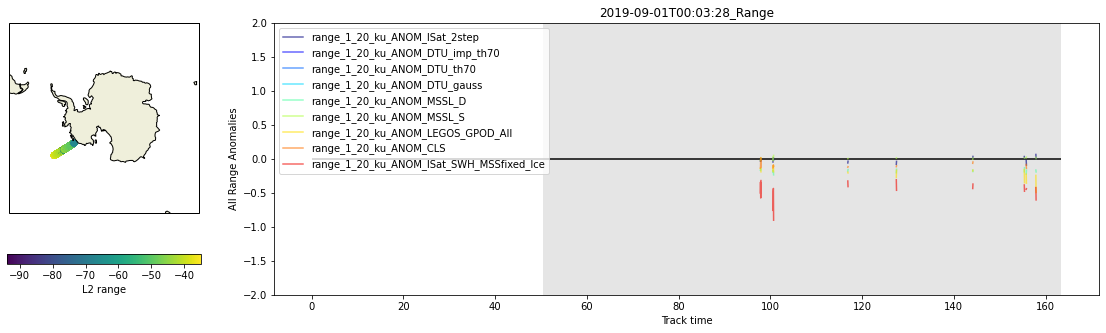

In [48]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku == 256)
# track.make_mask([],man_list=track.flag_surf_type_20_ku_CLS == 3)
ftime = track.time_20_ku[0]
f = plt.figure(figsize=[20,5])
aplt = 0.6
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],s=3)
s = ax.scatter(xy[:,0],xy[:,1],c=(track.alt_20_ku - track.range_1_20_ku))
cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
cax.set_label('L2 range')
# s = ax.scatter(xy[:,0],xy[:,1],c=(track.ssha_20_ku_LEGOS_GPOD_All))
# cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
# cax.set_label('LEGOS ssha_All')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime


ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)
p_vars = [p for p in track.vars if 'ANOM' in p]
p_vars = [p for p in     p_vars if 'range' in p]
# p_vars = [p for p in     p_vars if 'CLS' in p]
# p_vars = [p for p in     p_vars if 'ISat' in p]
# p_vars = [p for p in     p_vars if 'MSSL' in p]
# p_vars = [p for p in     p_vars if 'LEGOS' in p]
p_no = len(p_vars)
colors = pl.cm.jet(np.linspace(0,0.9,p_no))

pmin = []
pmax = []
ax.hlines([0.0],0,track.time_20_ku[-1]-ftime)
for pn,v in enumerate(p_vars):
    x = copy.copy(getattr(track,v))
    x[track.mask==0] = np.nan
    x[x.mask] = np.nan
    pmin.append(np.nanpercentile(x.compressed(),[ 3.1]))
    pmax.append(np.nanpercentile(x.compressed(),[ 97]))
    plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
                color=colors[pn])
#     print(np.nanmin(pmin),np.nanmax(pmax))
plt.ylim([np.nanmin(pmin),np.nanmax(pmax)])
plt.ylim([-2,2])
# plt.xlim([80,130])
# plt.ylabel('All LEGOS Anomalies')
plt.ylabel('All Range Anomalies')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
# Tstring = ant_plus.CSt2dt(ftime,string=True)
Tstring = ant_plus.CSt2dt(ftime).strftime('%Y-%m-%dT%H:%M:%S')
plt.title(Tstring+'_Range')

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_range_ANOM.png'
# plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_LEGOS_GPOD_ANOM.png'
# print('Saving: '+plot_name)
# f.savefig(fig_dir+plot_name,bbox_inches='tight')
plt.show()

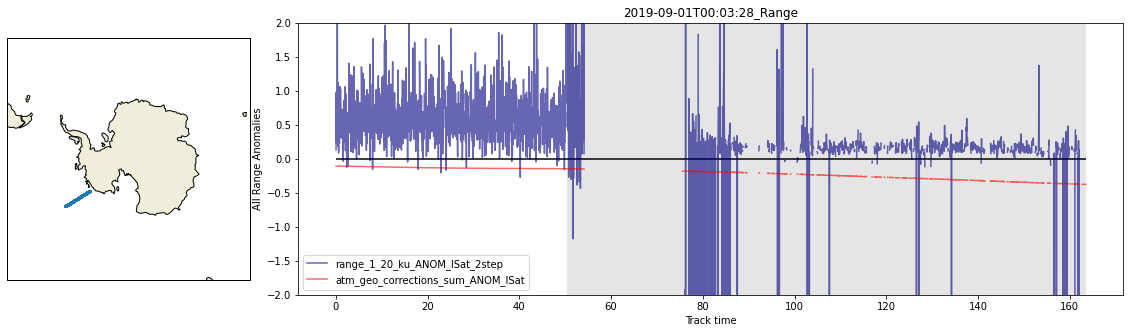

In [29]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 64)
# track.make_mask([],man_list=track.flag_surf_type_20_ku_CLS == 3)
ftime = track.time_20_ku[0]
f = plt.figure(figsize=[20,5])
aplt = 0.6
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],s=3)
# s = ax.scatter(xy[:,0],xy[:,1],c=(track.ssha_20_ku_LEGOS_GPOD_All))
# cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
# cax.set_label('LEGOS ssha_All')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime

institution =  'ISat'
    
ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)
p_vars = [p for p in track.vars if 'ANOM' in p]
p_vars = [p for p in     p_vars if institution in p]
# p_vars = [p for p in     p_vars if 'CLS' in p]
# p_vars = [p for p in     p_vars if 'ISat' in p]
# p_vars = [p for p in     p_vars if 'MSSL' in p]
# p_vars = [p for p in     p_vars if 'LEGOS' in p]
p_no = len(p_vars)
colors = pl.cm.jet(np.linspace(0,0.9,p_no))

pmin = []
pmax = []
ax.hlines([0.0],0,track.time_20_ku[-1]-ftime)
for pn,v in enumerate(p_vars):
    x = copy.copy(getattr(track,v))
    x[track.mask==0] = np.nan
    x[x.mask] = np.nan
    pmin.append(np.nanpercentile(x.compressed(),[ 3.1]))
    pmax.append(np.nanpercentile(x.compressed(),[ 97]))
    plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
                color=colors[pn])
#     print(np.nanmin(pmin),np.nanmax(pmax))
plt.ylim([np.nanmin(pmin),np.nanmax(pmax)])
plt.ylim([-2,2])
# plt.ylabel('All LEGOS Anomalies')
plt.ylabel('All Range Anomalies')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
# Tstring = ant_plus.CSt2dt(ftime,string=True)
Tstring = ant_plus.CSt2dt(ftime).strftime('%Y-%m-%dT%H:%M:%S')
plt.title(Tstring+'_Range')

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_'+institution+'_ANOM.png'
# print('Saving: '+plot_name)
f.savefig(fig_dir+plot_name,bbox_inches='tight')
plt.show()

Saving: CSAO_2019-09-01T00_03_28_extra_ANOM.png


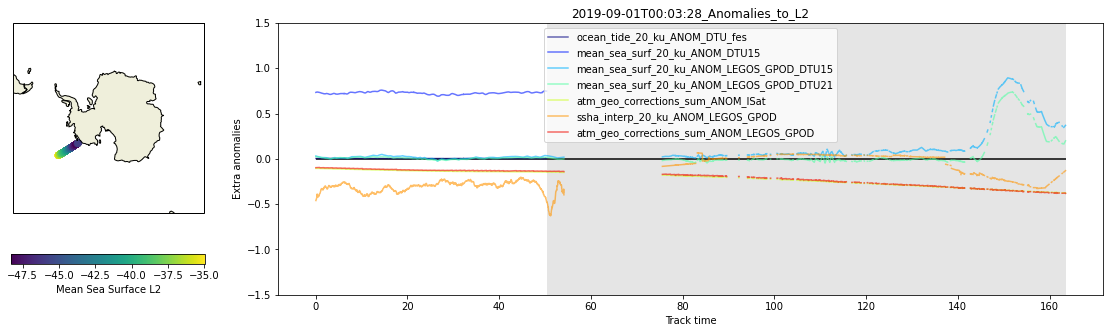

In [25]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 64)
f = plt.figure(figsize=[20,5])
aplt = 0.6
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],c=(track.mean_sea_surf_sea_ice_20_ku))
cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
cax.set_label('Mean Sea Surface L2')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime


ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)
p_vars = [p for p in track.vars if 'ANOM' in p]
p_vars = [p for p in     p_vars if 'range' not in p]
p_no = len(p_vars)
colors = pl.cm.jet(np.linspace(0,0.9,p_no))
pmin = []
pmax = []
ax.hlines([0.0],0,track.time_20_ku[-1]-ftime)
for pn,v in enumerate(p_vars):
    x = copy.copy(getattr(track,v))
    x[track.mask==0] = np.nan
    x[x.mask] = np.nan
    pmin.append(np.nanpercentile(x.compressed(),[ 3.1]))
    pmax.append(np.nanpercentile(x.compressed(),[ 97]))
    plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
                color=colors[pn])
#     print(np.nanmin(pmin),np.nanmax(pmax))
plt.ylim([np.nanmin(pmin),np.nanmax(pmax)])
plt.ylim([-1.5,1.5])
plt.ylabel('Extra anomalies')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
# Tstring = ant_plus.CSt2dt(ftime,string=True)
Tstring = ant_plus.CSt2dt(ftime).strftime('%Y-%m-%dT%H:%M:%S')
plt.title(Tstring+'_Anomalies_to_L2')

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_extra_ANOM.png'
print('Saving: '+plot_name)
f.savefig(fig_dir+plot_name,bbox_inches='tight')
plt.show()

/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-t

Saving: CSAO_2019-09-01T00_03_28.418137_range.png


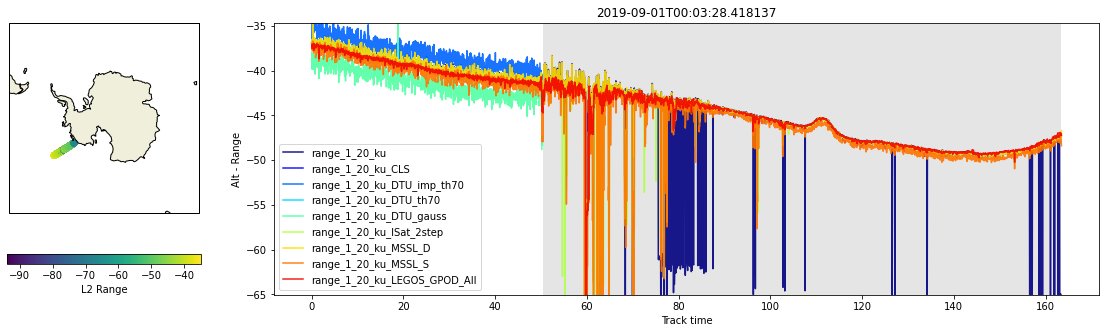

In [26]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 32)
f = plt.figure(figsize=[20,5])
aplt = 0.9
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],c=(track.alt_20_ku - track.range_1_20_ku))
cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
cax.set_label('L2 Range')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime



ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)

p_vars = [p for p in track.vars if 'range' in p]
# p_vars = p_vars+[p for p in track.vars if 'mean_sea' in p]
p_vars = [p for p in p_vars if 'ANOM' not in p]
p_no = len(p_vars)
colors = pl.cm.jet(np.linspace(0,0.9,p_no))
# p_vars = [p for p in p_vars if 'ISat'  in p]
pmin = np.nan
pmax = np.nan
for pn,v in enumerate(p_vars):
    x = copy.copy(getattr(track,v))
    x[track.mask==0] = np.nan
    x[x.mask] = np.nan
    if 'range' in v:
        x = track.alt_20_ku - x
    pmin = np.nanmin([np.nanpercentile(x.compressed(),[ 1.1]),pmin])
    pmax = np.nanmax([np.nanpercentile(x.compressed(),[98.9]),pmax])
    plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
                color=colors[pn])

plt.ylim([pmin,pmax])
# plt.ylim([-0.2,0.2])
# plt.ylim([10,pmax])
plt.ylabel('Alt - Range')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
Tstring = ant_plus.CSt2dt(ftime,string=True)
plt.title(Tstring)

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_range.png'
print('Saving: '+plot_name)
f.savefig(fig_dir+plot_name,bbox_inches='tight')
# f.savefig(plot_name)
plt.show()

/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-t

Saving: CSAO_2019-09-01T00_03_28.418137_Interp_for_Freeboard.png


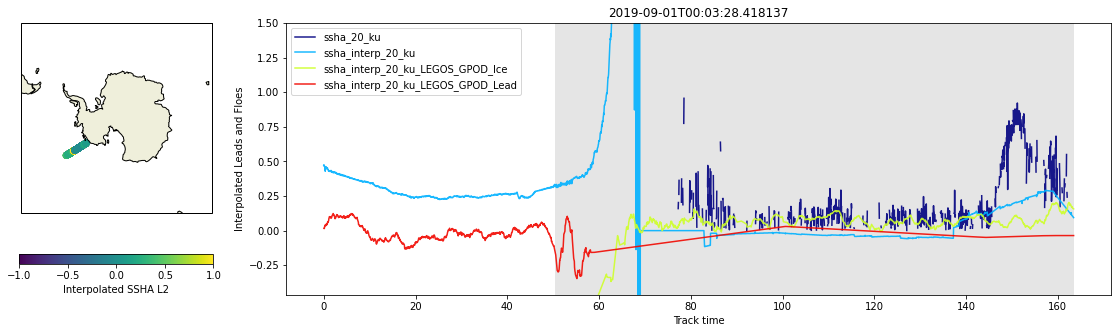

In [43]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 32)
f = plt.figure(figsize=[20,5])
aplt = 0.9
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],c=(track.ssha_interp_20_ku),vmin = -1,vmax=1)
cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
cax.set_label('Interpolated SSHA L2')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime



ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)

p_vars = [p for p in track.vars if 'interp' in p]
p_vars = [p for p in p_vars if 'ANOM' not in p]
p_vars = ['ssha_20_ku']+p_vars
p_no = len(p_vars)
colors = pl.cm.jet(np.linspace(0,0.9,p_no))
# p_vars = [p for p in p_vars if 'ISat'  in p]
pmin = np.nan
pmax = np.nan
for pn,v in enumerate(p_vars):
    x = copy.copy(getattr(track,v))
    x[track.mask==0] = np.nan
    x[x.mask] = np.nan
    if v =='ssha_20_ku':
        x[track.flag_surf_type_class_20_ku!=128] = np.nan
#         x = x + track.range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice
        x[x<0.0] = np.nan
    pmin = np.nanmin([np.nanpercentile(x.compressed(),[ 1.1]),pmin])
    pmax = np.nanmax([np.nanpercentile(x.compressed(),[98.9]),pmax])
    plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
                color=colors[pn])

plt.ylim([np.maximum(pmin,-1.5)
         ,np.minimum(pmax,1.5)])
# plt.ylim([-0.2,0.2])
# plt.ylim([10,pmax])
plt.ylabel('Interpolated Leads and Floes')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
Tstring = ant_plus.CSt2dt(ftime,string=True)
plt.title(Tstring)

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_Interp_for_Freeboard.png'
print('Saving: '+plot_name)
# f.savefig(plot_name)
plt.show()

/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/miniconda3/envs/harry/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-t

Saving: CSAO_2019-09-01T00_03_28.418137_Interp_for_Freeboard.png


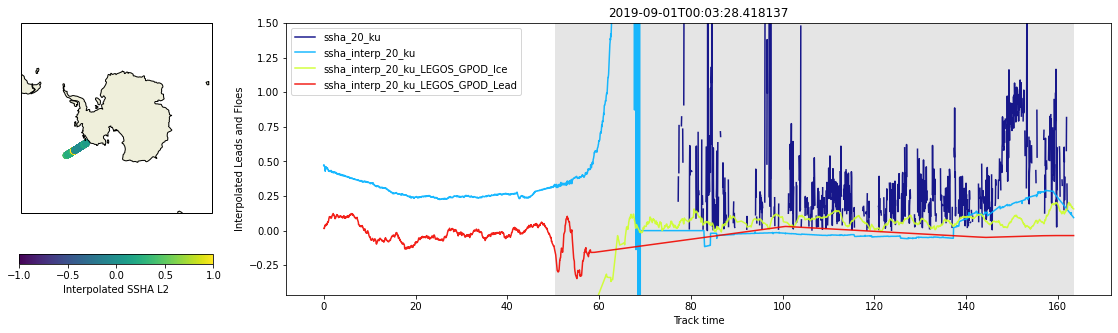

In [42]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 32)
f = plt.figure(figsize=[20,5])
aplt = 0.9
mksz = 0.8
pstlye = '-'

ax = plt.subplot2grid([1,4],[0,0],projection = m)
ax.set_extent([-180, 180, -90, -50], proj_cart)
xy = m.transform_points(proj_cart,track.lon_20_ku,track.lat_20_ku)
s = ax.scatter(xy[:,0],xy[:,1],c=(track.ssha_interp_20_ku),vmin = -1,vmax=1)
cax = plt.colorbar(s,orientation="horizontal",shrink=0.8)
cax.set_label('Interpolated SSHA L2')
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)

Icedesc = np.sum(np.diff(track.NSIDC_nasa))<0
conc_lim1 = 0.15
conc_lim2 = 0.85
if Icedesc:
    icelim=[
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa<conc_lim2)]-ftime,
            track.time_20_ku[0]-ftime]
else:
    icelim=[track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim1)]-ftime,
            track.time_20_ku[np.argmax(track.NSIDC_nasa>conc_lim2)]-ftime,
            track.time_20_ku[track.n_u-1]-ftime]
if (track.NSIDC_nasa<conc_lim2).all():icelim[1] = track.time_20_ku[track.n_u-1]-ftime



ax = plt.subplot2grid([1,4],[0,1],colspan=3)
plt.axvspan(icelim[0],icelim[1],facecolor='k',alpha=0.1)
plt.axvspan(icelim[1],icelim[2],facecolor='k',alpha=0.2)


pmin = np.nan
pmax = np.nan
x = copy.copy(getattr(track,'freeboard_20_ku'))
x[track.mask==0] = np.nan
x[x.mask] = np.nan
x[track.flag_surf_type_class_20_ku!=128] = np.nan
pmin = np.nanmin([np.nanpercentile(x.compressed(),[ 1.1]),pmin])
pmax = np.nanmax([np.nanpercentile(x.compressed(),[98.9]),pmax])
plt.plot(track.time_20_ku-ftime,x,pstlye,alpha=aplt,markersize=mksz,
            color=colors[pn])

plt.ylim([np.maximum(pmin,-1.5)
         ,np.minimum(pmax,1.5)])
# plt.ylim([-0.2,0.2])
# plt.ylim([10,pmax])
plt.ylabel('Interpolated Leads and Floes')
plt.xlabel('Track time')
xplot_r = [0,track.time_20_ku[track.n_u-1]-ftime]

plt.legend(p_vars)
# plt.ylim([10,pmax])
Tstring = ant_plus.CSt2dt(ftime,string=True)
plt.title(Tstring)

plot_name = 'CSAO_'+Tstring.replace(':','_',100)+'_Freeboard.png'
print('Saving: '+plot_name)
# f.savefig(plot_name)
plt.show()

In [6]:
track.make_mask([],man_list=track.flag_surf_type_class_20_ku >= 64)
for v in track.vars:
#     if 'range' in v and 'ANOM' not in v:
#     if 'range' in v and 'ISat' in v:
    if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x[track.mask],[25,50,75])))

NameError: name 'track' is not defined

In [108]:
### ocean
[[bin(d),s] for d,s in zip(track.flag_height_20_ku.data,track.flag_surf_type_class_20_ku) if s ==64][:10]

[['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64],
 ['0b1110101111101100001000000000', 64]]